The intention of this notebook is to track and summary the performances of the run models.

In [1]:
!pip install --force-reinstall git+https://github.com/pyg-team/pytorch_geometric.git
!pip install matplotlib
!pip install seaborn 
!pip install tabulate
!pip install networkx

  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-tisoby0j
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-tisoby0j
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 29b20796d9e3fca1662029d1083d508634b7593e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached scikit_learn-1.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Using cached psutil-5.9.4-cp36-abi3-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (280 kB)
  Using cached scipy-1.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.4 MB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached requests-2.28.2-py3-none-any.whl (62 kB)
  Using cached tqdm-4.65.0-

In [3]:
!conda list

# packages in environment at /home/ec2-user/anaconda3/envs/gnn:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                  2_kmp_llvm    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
asttokens                 2.0.5              pyhd3eb1b0_0    anaconda
backcall                  0.2.0              pyhd3eb1b0_0    anaconda
blas                      1.0                         mkl    conda-forge
brotlipy                  0.7.0                    pypi_0    pypi
bzip2                     1.0.8                h7f98852_4    conda-forge
ca-certificates           2023.01.10           h06a4308_0    anaconda
certifi                   2022.12.7                pypi_0    pypi
cffi                      1.15.1                   pypi_0    pypi
charset-normalizer        3.0.1                    pypi_0    pypi
colorama                  0.

In [71]:
import sys
import os
import pickle
import random
import torch
import torch.nn as nn
import tqdm as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sys.path.append('/home/ec2-user/SageMaker/projects/gnn/GNN-material/src')
sys.path = list(set(sys.path))

from tabulate import tabulate
from models.TabTab.tab_tab     import TabTab_v1, TabTabDataset, create_tab_tab_datasets, BuildTabTabModel
from models.GraphTab.graph_tab import GraphTab_v1, GraphTab_v2, GraphTabDataset, create_graph_tab_datasets, BuildGraphTabModel
from models.TabGraph.tab_graph import TabGraph_v1, TabGraphDataset, create_tab_graph_datasets, BuildTabGraphModel
from utils.global_vars import PlottingParameters
from torch_geometric.loader  import DataLoader as PyG_DataLoader

os.environ['TORCH'] = torch.__version__

print(f"Python version: {'.'.join(map(str, sys.version_info[:3]))}")
print(f"Pytorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

Python version: 3.10.4
Pytorch version: 1.12.0
CUDA version: 10.2


In [9]:
!ls -lh ../performances

total 143M
-rw-rw-r-- 1 ec2-user ec2-user 1.7M Dec  8 13:54 ic50s_test_gdsc2_v1_100epochs.csv
drwxrwxr-x 3 ec2-user ec2-user 4.0K Dec  8 13:03 imgs
-rw-rw-r-- 1 ec2-user ec2-user  29K Mar  5 17:27 logfile_model_graphgraph_v1_gdsc2_950_42_040323Thresh950GATConv3GINConvMax100Epochs
-rw-rw-r-- 1 ec2-user ec2-user 7.4K Mar  4 17:29 logfile_model_graphgraph_v1_gdsc2_990_42_040323GATConv3GINConvMax100Epochs
-rw-rw-r-- 1 ec2-user ec2-user  34K Feb 16 21:40 logfile_model_graphgraph_v1_gdsc2_990_42_130223GATConv2GINConvMax
-rw-rw-r-- 1 ec2-user ec2-user  36K Feb 16 21:40 logfile_model_graphgraph_v1_gdsc2_990_42_130223GATConv2GINConvMax200Epochs
-rw-rw-r-- 1 ec2-user ec2-user  36K Feb 14 02:39 logfile_model_graphgraph_v1_gdsc2_990_42_130223GATConv3GINConvMax200Epochs128only
-rw-rw-r-- 1 ec2-user ec2-user  12K Feb 16 21:40 logfile_model_graphgraph_v1_gdsc2_990_42_130223GATConv3GINConvMean200Epochs
-rw-rw-r-- 1 ec2-user ec2-user 143K Feb 16 00:41 logfile_model_graphgraph_v1_gdsc2_990_42_150223GCNC

<ins>Contents of this notebook</ins>

- [x] Compared performances of v1 models TabTab, GraphTab, TabGraph
- [x] Plot the predicted IC50 values against the actual IC50 values for the test set for each model
    - x-axis = observed IC50 values
    - y-axis = predicted IC50 values
    - include histograms on the edges of the scatter plot
- [ ] Calculate average predicted IC50 value per drug
    - [ ] For that, save the cell-line name an drug as well in the `ic50s` table
    - [ ] standardize by dividing by the average per drug
    - [ ] compare the top 10 and bottom 10 drugs
- [ ] Ran GNNExplainer on GraphTab
- [ ] Ran GNNExplainer on TabGraph

# Model Performances

## Helpers

In [80]:
def plot_model_results(df, model):
    fig, axs = plt.subplots(2, 4, figsize=(30, 10))

    sns.lineplot(x='epochs', y='mse', hue='dataset', data=df, ax=axs[0,0]);
    sns.lineplot(x='epochs', y='rmse', hue='dataset', data=df, ax=axs[0,1]);
    sns.lineplot(x='epochs', y='mae', hue='dataset', data=df, ax=axs[1,0]);
    sns.lineplot(x='epochs', y='pcorr', hue='dataset', data=df, ax=axs[1,1]);

    axs[0,0].set_title('MSE');
    axs[0,1].set_title('RMSE');
    axs[1,0].set_title('MAE');
    axs[1,1].set_title('Pearson Correlation');

    sns.boxplot(x='mse', y='dataset', data=df, showfliers=False, ax=axs[0,2]);
    sns.boxplot(x='rmse', y='dataset', data=df, showfliers=False, ax=axs[0,3]);
    sns.boxplot(x='mae', y='dataset', data=df, showfliers=False, ax=axs[1,2]);
    sns.boxplot(x='pcorr', y='dataset', data=df, showfliers=False, ax=axs[1,3]);

    axs[0,2].set_title('MSE'); axs[0,2].set(xlabel=None);
    axs[0,3].set_title('RMSE'); axs[0,3].set(xlabel=None);
    axs[1,2].set_title('MAE'); axs[1,2].set(xlabel=None);
    axs[1,3].set_title('Pearson Correlation'); axs[1,3].set(xlabel=None);

    fig.suptitle(f'{model} Model');
    plt.show();
    
class HyperParameters:
    def __init__(self, batch_size, lr, train_ratio, val_ratio, 
                 num_epochs, seed='12345', num_workers=0):
        self.BATCH_SIZE = batch_size
        self.LR = lr
        self.TRAIN_RATIO = train_ratio
        self.TEST_VAL_RATIO = 1-self.TRAIN_RATIO
        self.VAL_RATIO = val_ratio
        self.NUM_EPOCHS = num_epochs
        self.RANDOM_SEED = seed
        self.NUM_WORKERS = num_workers

def get_data_for_model_validation(mod, 
                                  create, 
                                  Model, 
                                  BuildModel, 
                                  drm, 
                                  cl, 
                                  sm, 
                                  seed, 
                                  approach):
    """Returns instantiated model class for the given model type and datasets."""
    hyper_params = HyperParameters(
        batch_size=mod['batch_size'], 
        lr=mod['learning_rate'], 
        train_ratio=mod['train_ratio'], 
        val_ratio=mod['val_ratio'], 
        num_epochs=mod['epoch'], 
        seed=seed,
        num_workers=0
    )
    
#     print(drm.shape)
#     print(cl.shape)
#     print(sm.shape)

    train_loader, test_loader, val_loader = create(drm, cl, sm, hyper_params)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if approach in ['TabTab', 'TabGraph']:
        model = Model(cl.shape[1]).to(device)
    elif approach == 'GraphTab':
        model = Model().to(device)
    model.load_state_dict(mod['model_state_dict'], strict=False)
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), 
                                 lr=mod['learning_rate'])    

    build_model = BuildModel(
        model=model, 
        criterion=loss_func, 
        optimizer=optimizer,
        num_epochs=mod['epoch'], 
        train_loader=train_loader,
        test_loader=test_loader, 
        val_loader=val_loader, 
        device=device
    )
    
    return build_model

def calculate_and_return_metrics(model, 
                                 test_res, 
                                 ic50s, 
                                 model_name):
    """Calculate and return MSE, RMSE, MAE, r2 and pearson correlation coefficient
    for train, validation and test set for the given model."""
    mse_train, rmse_train, mae_train, r2_train, pcc_train, scc_train, _, _ = model.validate(model.train_loader)
    mse_val, rmse_val, mae_val, r2_val, pcc_val, scc_val, _, _ = model.validate(model.val_loader)
    mse_test, rmse_test, mae_test, r2_test, pcc_test, scc_test, y_true_test, y_pred_test = model.validate(model.test_loader)

    test_res.iloc[test_res.model==model_name, 1:] = pd.Series([
        mse_test.item(), rmse_test.item(), mae_test, r2_test, pcc_test, scc_test
    ])

    results = tabulate(
        [
            ['mse', 'rmse', 'mae', 'r2', 'pcc', 'scc'],
            ['train', mse_train, rmse_train, mae_train, r2_train, pcc_train, scc_train],
            ['validation', mse_val, rmse_val, mae_val, r2_val, pcc_val, scc_val],
            ['test', mse_test, rmse_test, mae_test, r2_test, pcc_test, scc_test]
        ], headers='firstrow')
    print(results)

    data = np.stack([
        np.repeat(model_name, len(y_true_test)),
        list([v.item() for v in y_true_test]), 
        list([v.item() for v in y_pred_test])
    ], axis=1)

    if model_name not in list(ic50s.model.unique()):
        ic50s = pd.concat([ic50s, pd.DataFrame(data, columns=ic50s.columns)], axis=0)  
        
    return test_res, ic50s

def plot_observed_vs_predicted_ln_ic50s(ic50s: pd.DataFrame, 
                                        rmse: float,
                                        pcc: float,
                                        scc: float,
                                        model_name: str,
                                        version: str):
    """Plot the observed ln(IC50) value against the predicted ones."""
    ax = sns.jointplot(x='y_true', y='y_pred', data=ic50s, kind='hex',
                       marginal_kws={'bins': 35});
    ax.fig.set_size_inches(8, 6);

    plt.xlabel(r'Observed $\ln(IC_{50})$');
    plt.ylabel(r'Predicted $\ln(IC_{50})$');
    plt.xticks(np.arange(-10, 11, 2.5));
    plt.yticks(np.arange(-10, 11, 2.5));

    plt.text(-9, 8.5, 
             f"RMSE={round(rmse, 2)}", 
             horizontalalignment='left', size=18, color='black');
    plt.text(-9, 7.4, 
             f"PCC={round(pcc, 2)}", 
             horizontalalignment='left', size=18, color='black');
    plt.text(-9, 6.3, 
             f"SCC={round(scc, 2)}", 
             horizontalalignment='left', size=18, color='black');    

    plt.title(f'{model_name} {version}', y=1.25);
    plt.show();
    
    return ax.fig


class GraphTabDataset(Dataset): 
    def __init__(self, cl_graphs, drugs, drug_response_matrix):
        super().__init__()

        # SMILES fingerprints of the drugs and cell-line graphs.
        self.drugs = drugs
        self.cell_line_graphs = cl_graphs

        # Lookup datasets for the response values.
        drug_response_matrix.reset_index(drop=True, inplace=True)
        self.cell_lines = drug_response_matrix['CELL_LINE_NAME']
        self.drug_ids = drug_response_matrix['DRUG_ID']
        self.drug_names = drug_response_matrix['DRUG_NAME']
        self.ic50s = drug_response_matrix['LN_IC50']

    def len(self):
        return len(self.ic50s)

    def get(self, idx: int):
        """
        Returns a tuple of cell-line, drug and the corresponding ln(IC50)
        value for a given index.

        Args:
            idx (`int`): Index to specify the row in the drug response matrix.  
        Returns:
            `Tuple[torch_geometric.data.data.Data, np.ndarray, np.float64]`:
            Tuple of a cell-line graph, drug SMILES fingerprint and the 
            corresponding ln(IC50) value.
        """
        assert self.cell_lines.iloc[idx] in self.cell_line_graphs.keys(), \
            f"Didn't find CELLLINE: {self.cell_line_graphs.iloc[idx]}"        
        assert self.drug_ids.iloc[idx] in self.drugs.keys(), \
            f"Didn't find DRUG: {self.drug_ids.iloc[idx]}"
        return (self.cell_line_graphs[self.cell_lines.iloc[idx]], 
                self.drugs[self.drug_ids.iloc[idx]],
                self.ic50s.iloc[idx])

    def print_dataset_summary(self):
        print(f"GraphTabDataset Summary")
        print(f"{23*'='}")
        print(f"# observations : {len(self.ic50s)}")
        print(f"# cell-lines   : {len(np.unique(self.cell_lines))}")
        print(f"# drugs        : {len(np.unique(self.drug_names))}")
        print(f"# genes        : {self.cell_line_graphs[next(iter(self.cell_line_graphs))].x.shape[0]}")
        
def create_graph_tab_datasets(drm, cl_graphs, drug_mat, args):
    print(f"Full     shape: {drm.shape}")
    train_set, test_val_set = train_test_split(drm, 
                                               test_size=args.TEST_VAL_RATIO, 
                                               random_state=args.RANDOM_SEED,
                                               stratify=drm['CELL_LINE_NAME'])
    test_set, val_set = train_test_split(test_val_set,
                                         test_size=args.VAL_RATIO,
                                         random_state=args.RANDOM_SEED,
                                         stratify=test_val_set['CELL_LINE_NAME'])
    print(f"train    shape: {train_set.shape}")
    print(f"test_val shape: {test_val_set.shape}")
    print(f"test     shape: {test_set.shape}")
    print(f"val      shape: {val_set.shape}")

    train_dataset = GraphTabDataset(cl_graphs=cl_graphs, drugs=drug_mat, drug_response_matrix=train_set)
    test_dataset = GraphTabDataset(cl_graphs=cl_graphs, drugs=drug_mat, drug_response_matrix=test_set)
    val_dataset = GraphTabDataset(cl_graphs=cl_graphs, drugs=drug_mat, drug_response_matrix=val_set)

    print("train_dataset:")
    train_dataset.print_dataset_summary()
    print("test_dataset:")
    test_dataset.print_dataset_summary()
    print("val_dataset:")
    val_dataset.print_dataset_summary()

    # TODO: try out different `num_workers`.
    train_loader = PyG_DataLoader(dataset=train_dataset, batch_size=args.BATCH_SIZE, shuffle=True, num_workers=args.NUM_WORKERS)
    test_loader = PyG_DataLoader(dataset=test_dataset, batch_size=args.BATCH_SIZE, shuffle=True, num_workers=args.NUM_WORKERS)
    val_loader = PyG_DataLoader(dataset=val_dataset, batch_size=args.BATCH_SIZE, shuffle=True, num_workers=args.NUM_WORKERS)

    return train_loader, test_loader, val_loader           

## Train, Validation and Test Results

In [11]:
# --- Results for combined_score_thresh=900 & GDSC2---
tt = torch.load('../performances/model_performance_TabTab_gdsc2_990.pth')
gt = torch.load('../performances/model_performance_GraphTab_v2_gdsc2_990.pth')
tg = torch.load('../performances/model_performance_TabGraph_gdsc2_990.pth')
device = torch.device('cpu')
tt.keys()

dict_keys(['epoch', 'batch_size', 'learning_rate', 'train_ratio', 'val_ratio', 'model_state_dict', 'optimizer_state_dict', 'train_performances', 'val_performances'])

In [12]:
models = {
    'TabTab': tt,
    'GraphTab': gt,
    'TabGraph': tg
}

In [13]:
train_val_per_model = dict()

for name, res in models.items():
    ds = ['train', 'val']
    dfs = []
    for d in ds:
        epochs = range(1, res['epoch']+1)
        mse = [x.item() for x in res[f'{d}_performances']['mse']]
        rmse = [x.item() for x in res[f'{d}_performances']['rmse']]
        mae = [x.item() for x in res[f'{d}_performances']['mae']]
        r2 = [x.item() for x in res[f'{d}_performances']['r2']]
        pcorr = [x[0] if d=='train' else x for x in res[f'{d}_performances']['pcorr']]
        if d=='train':
            epochtimes = [x for x in res[f'{d}_performances']['epoch_times']]
        else: 
            epochtimes = [None for e in epochs]
            
        dfs.append(pd.DataFrame({
            'dataset': d,
            'epochs': epochs,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'pcorr': pcorr,
            'epoch_times': epochtimes
        }))  
        
    trainval = pd.concat([dfs[0], dfs[1]])
    train_val_per_model[name] = trainval
    
train_val_per_model.keys()

dict_keys(['TabTab', 'GraphTab', 'TabGraph'])

In [14]:
test_res = pd.DataFrame({
    'model': ['TabTab', 'GraphTab', 'TabGraph'],
    'mse': [None, None, None],
    'rmse': [None, None, None],
    'mae': [None, None, None],
    'r2': [None, None, None],
    'pcc': [None, None, None],
    'scc': [None, None, None]
})
test_res

,model,mse,rmse,mae,r2,pcc,scc
0,TabTab,None,None,None,None,None,None
1,GraphTab,None,None,None,None,None,None
2,TabGraph,None,None,None,None,None,None


In [15]:
# TODO: Save the cell-line name and drug as well in the below table.
ic50s = pd.DataFrame(columns=['model', 'y_true', 'y_pred'])
ic50s

,model,y_true,y_pred


### TabTab

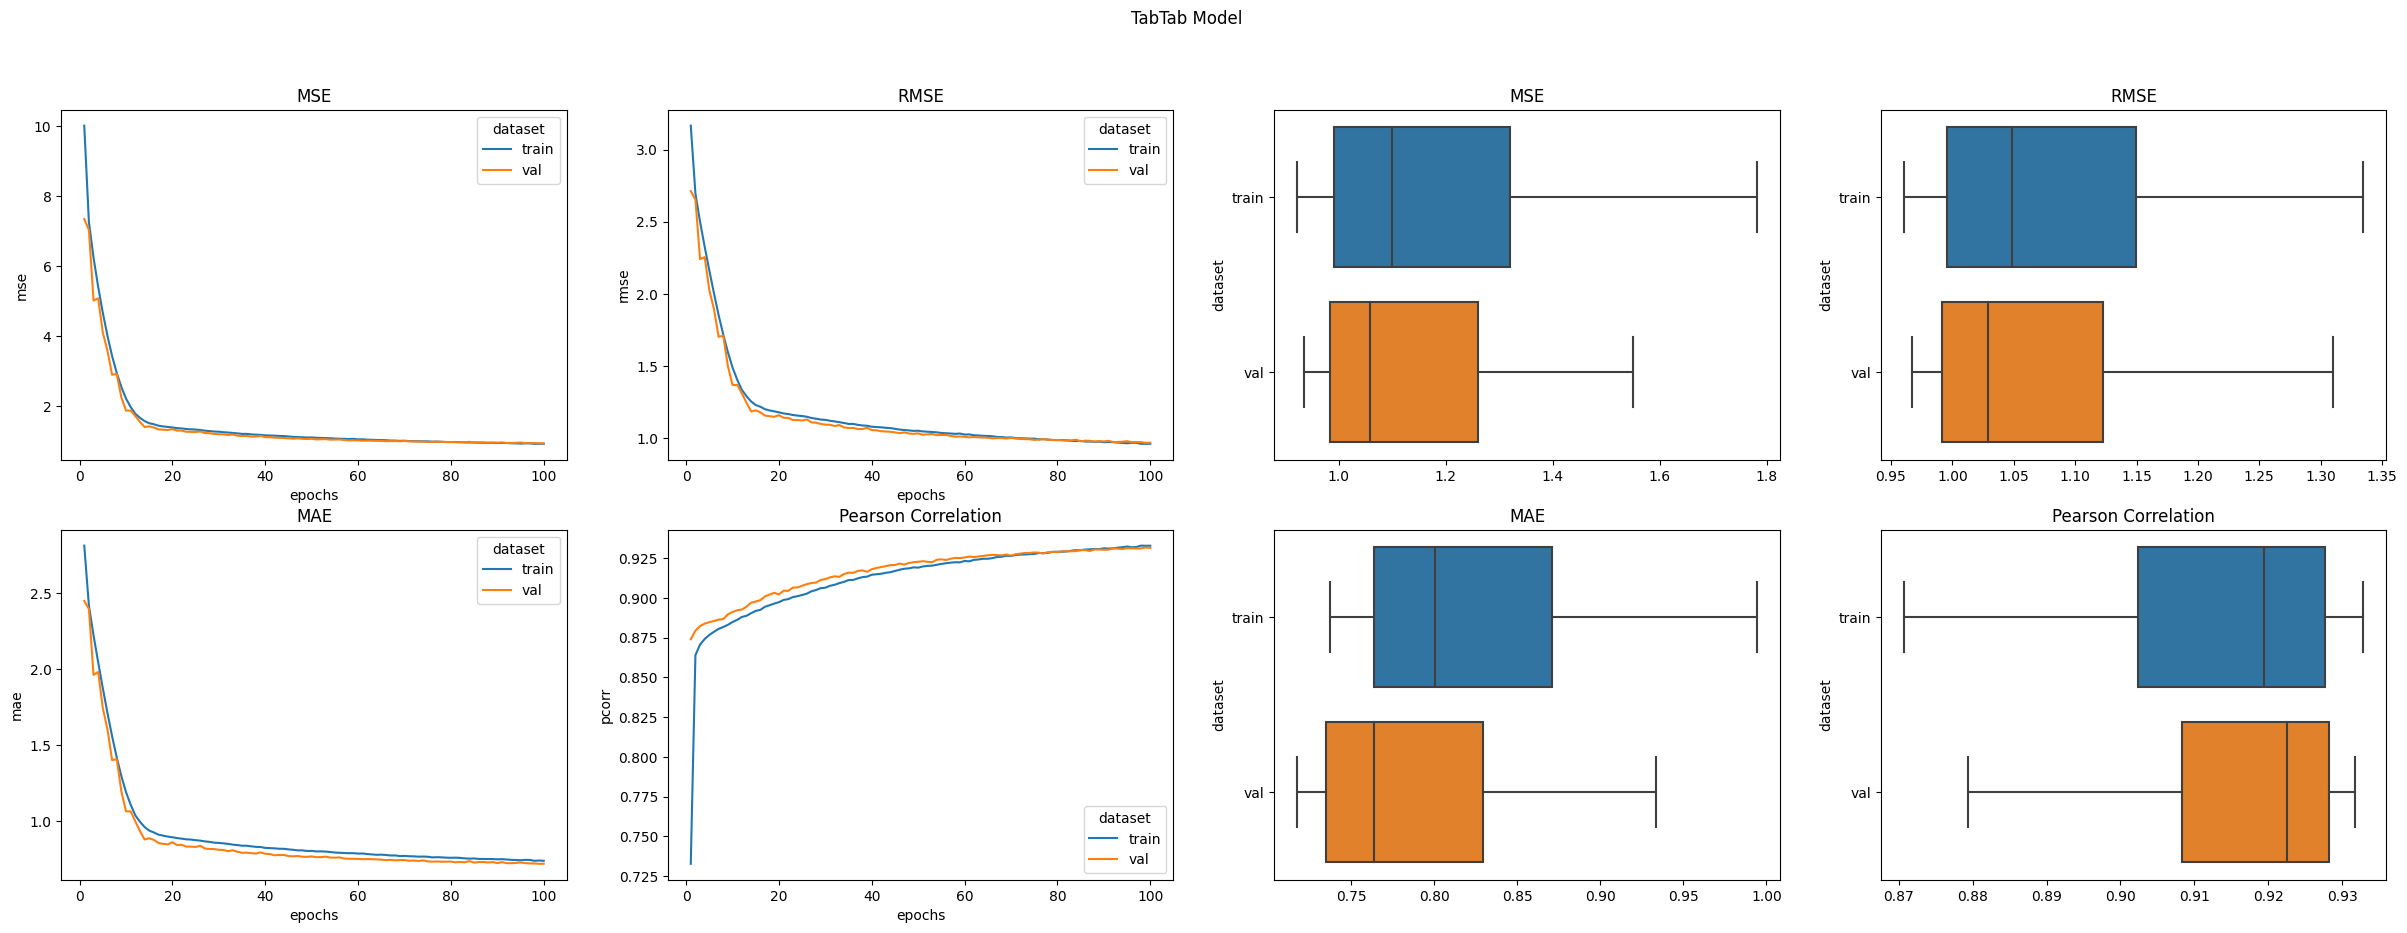

In [18]:
plot_model_results(train_val_per_model['TabTab'], 'TabTab')

In [16]:
print(f"Unique cell-lines: {drm.CELL_LINE_NAME.nunique()}")
print(f"Unique drugs     : {drm.DRUG_ID.nunique()}")
drm.head(3)

NameError: name 'drm' is not defined

In [17]:
drm[drm.CELL_LINE_NAME=='PFSK-1'].LN_IC50.hist(bins=50);

NameError: name 'drm' is not defined

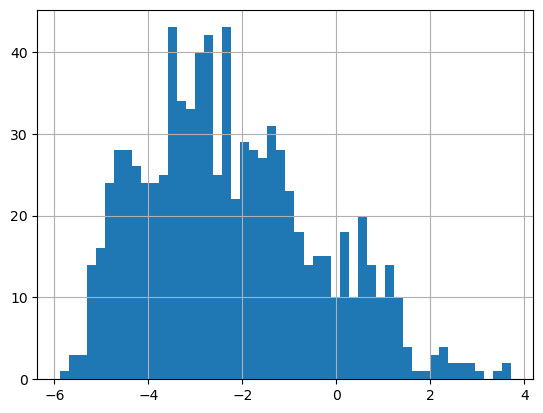

In [36]:
drm[drm.DRUG_ID==1003].LN_IC50.hist(bins=50);

In [44]:
'CR-12' in list(drm.CELL_LINE_NAME.unique())

False

In [59]:
from torch_geometric.data    import Dataset
from sklearn.model_selection import train_test_split
# from torch_geometric.loader  import DataLoader as PyG_DataLoader
from torch.utils.data        import DataLoader
from torch_geometric.nn      import Sequential, GCNConv, global_mean_pool, global_max_pool
from tqdm                    import tqdm
from time                    import sleep
from sklearn.metrics         import r2_score, mean_absolute_error
from scipy.stats             import pearsonr, spearmanr


class TabTabDataset(Dataset): 
    def __init__(self, cl_mat, drug_mat, drm):
        super().__init__()      
        self.cl_mat = cl_mat
        self.drug_mat = drug_mat

        drm.reset_index(drop=True, inplace=True)
        self.cls = drm['CELL_LINE_NAME']
        self.drug_ids = drm['DRUG_ID']
        self.drug_names = drm['DRUG_NAME']
        self.ic50s = drm['LN_IC50']

    def len(self):
        return len(self.ic50s)

    def get(self, idx: int):
        """
        Returns a tuple of cell-line-gene features, drug smiles fingerprints 
        and the corresponding ln(IC50) values for a given index.

        Args:
            idx (`int`): Index to specify the row in the drug response matrix.  
        Returns
            `Tuple[np.ndarray, np.ndarray, np.float64]]`: Tuple of cell-line 
                gene feature values, drug SMILES fingerprints and the 
                corresponding ln(IC50) target values.
        """  
        return (self.cl_mat.loc[self.cls.iloc[idx]], 
                self.drug_mat.loc[self.drug_ids.iloc[idx]],
                self.ic50s.iloc[idx])

    def print_dataset_summary(self):
        print(f"TabTabDataset Summary")
        print(21*'=')
        print(f"# observations : {len(self.ic50s)}")
        print(f"# cell-lines   : {len(np.unique(self.cls))}")
        print(f"# drugs        : {len(np.unique(self.drug_names))}")
        print(f"# genes        : {len([col for col in self.cl_mat.columns[1:] if '_cnvg' in col])}")


def _collate_tab_tab(samples):
    cell_lines, drugs, ic50s = map(list, zip(*samples))
    cell_lines = [torch.tensor(cl, dtype=torch.float64) for cl in cell_lines]
    drugs = [torch.tensor(drug, dtype=torch.float64) for drug in drugs]
    
    return torch.stack(cell_lines, 0), torch.stack(drugs, 0), torch.tensor(ic50s)

def create_tab_tab_datasets(drm, cl_mat, drug_mat, args):
    train_set, test_val_set = train_test_split(drm, 
                                               test_size=args.TEST_VAL_RATIO,
                                               random_state=args.RANDOM_SEED,
                                               stratify=drm['CELL_LINE_NAME'])
    test_set, val_set = train_test_split(test_val_set, 
                                         test_size=args.VAL_RATIO, 
                                         random_state=args.RANDOM_SEED,
                                         stratify=test_val_set['CELL_LINE_NAME'])

    print(f"train_set.shape: {train_set.shape}")
    print(f"test_set.shape: {test_set.shape}")
    print(f"val_set.shape: {val_set.shape}")

    train_dataset = TabTabDataset(cl_mat=cl_mat, 
                                  drug_mat=drug_mat, 
                                  drm=train_set)
    test_dataset = TabTabDataset(cl_mat=cl_mat, 
                                 drug_mat=drug_mat, 
                                 drm=test_set)
    val_dataset = TabTabDataset(cl_mat=cl_mat, 
                                drug_mat=drug_mat, 
                                drm=val_set)

    print("train_dataset"); train_dataset.print_dataset_summary()
    print("test_dataset"); test_dataset.print_dataset_summary()
    print("val_dataset"); val_dataset.print_dataset_summary()

    train_loader = DataLoader(dataset=train_dataset, 
                              batch_size=args.BATCH_SIZE, 
                              shuffle=True, 
                              collate_fn=_collate_tab_tab, 
                              num_workers=args.NUM_WORKERS)
    test_loader = DataLoader(dataset=test_dataset, 
                             batch_size=args.BATCH_SIZE, 
                             shuffle=True, 
                             collate_fn=_collate_tab_tab, 
                             num_workers=args.NUM_WORKERS)
    val_loader = DataLoader(dataset=val_dataset, 
                            batch_size=args.BATCH_SIZE, 
                            shuffle=True, 
                            collate_fn=_collate_tab_tab, 
                            num_workers=args.NUM_WORKERS)  

    return train_loader, test_loader, val_loader 

In [60]:
import inspect 

print(inspect.isabstract(TabTabDataset)) # output: True

False


In [61]:
drm.head(2)

,DATASET,CELL_LINE_NAME,DRUG_NAME,DRUG_ID,SANGER_MODEL_ID,AUC,RMSE,Z_SCORE,LN_IC50
333161,GDSC2,PFSK-1,Camptothecin,1003,SIDM01132,0.930105,0.088999,0.432482,-1.462148
333162,GDSC2,A673,Camptothecin,1003,SIDM00848,0.614932,0.111423,-1.420322,-4.869447


In [62]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

with open('../../data/processed/' + 'gdsc2_drm.pkl', 'rb') as f: 
    drm = pickle.load(f)
with open('../../data/processed/gdsc2/990/' + f'thresh_gdsc2_990_gene_mat.pkl', 'rb') as f: 
    cl = pickle.load(f)
with open('../../data/processed/gdsc2/' + f'gdsc2_smiles_mat.pkl', 'rb') as f:
    smiles = pickle.load(f)
cl.set_index('CELL_LINE_NAME', inplace=True)
smiles.set_index('DRUG_ID', inplace=True)    

model = get_data_for_model_validation(
    tt, 
    create_tab_tab_datasets,
    TabTab_v1, 
    BuildTabTabModel,
    drm, 
    cl, 
    smiles,
    seed,
    'TabTab'
)

(137835, 9)
(856, 1172)
(181, 256)
train_set.shape: (110268, 9)
test_set.shape: (13783, 9)
val_set.shape: (13784, 9)
train_dataset
TabTabDataset Summary
# observations : 110268
# cell-lines   : 856
# drugs        : 181
# genes        : 293
test_dataset
TabTabDataset Summary
# observations : 13783
# cell-lines   : 856
# drugs        : 181
# genes        : 293
val_dataset
TabTabDataset Summary
# observations : 13784
# cell-lines   : 856
# drugs        : 181
# genes        : 293


In [63]:
test_res, ic50s = calculate_and_return_metrics(model, test_res, ic50s, 'TabTab')

Iteration (val): 100%|██████████| 14/14 [00:07<00:00,  2.00it/s]


                 mse      rmse       mae        r2       pcc       scc
----------  --------  --------  --------  --------  --------  --------
train       0.701774  0.83772   0.635753  0.901149  0.949452  0.928013
validation  0.937737  0.968368  0.717931  0.867462  0.931427  0.909129
test        0.9352    0.967057  0.71581   0.868427  0.931941  0.911884


### GraphTab

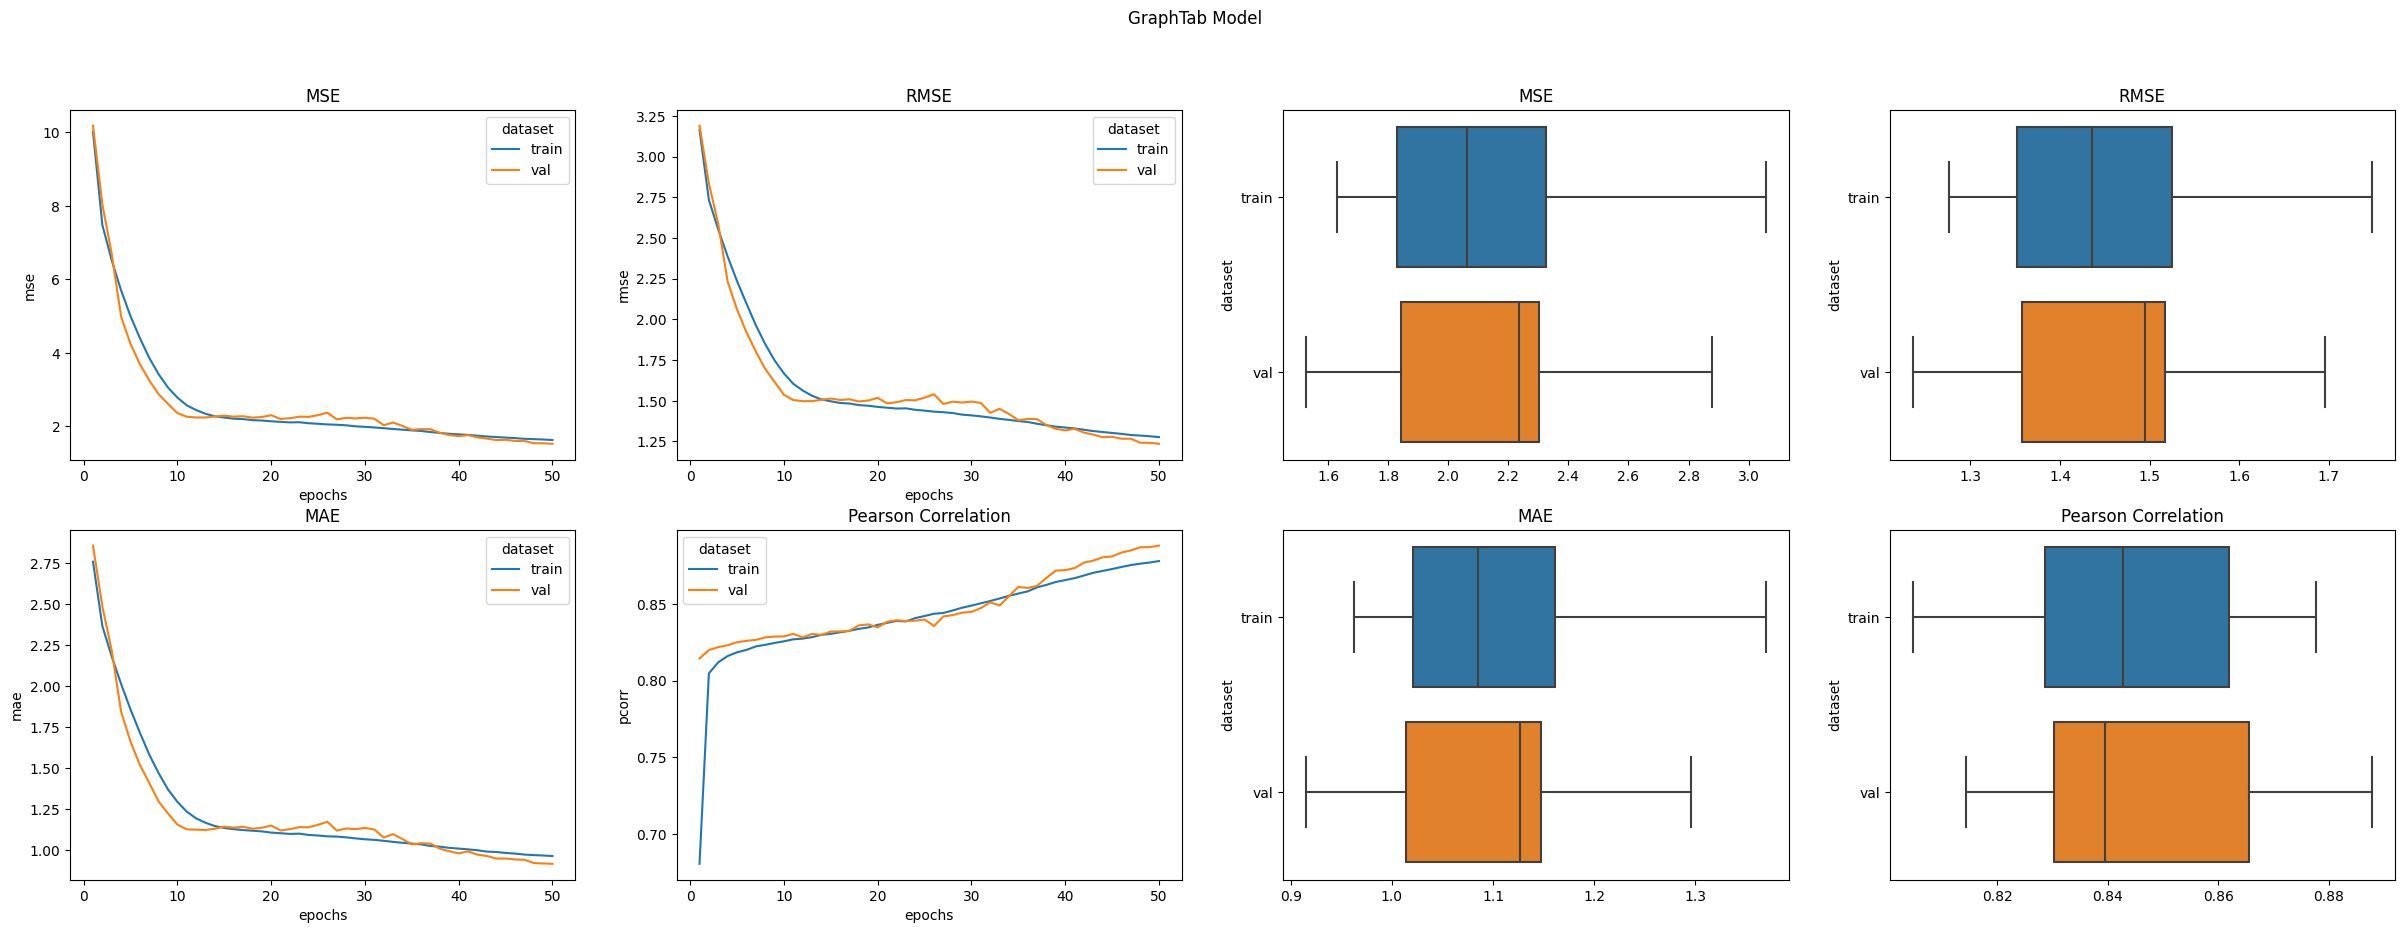

In [64]:
plot_model_results(train_val_per_model['GraphTab'], 'GraphTab')

In [77]:
gt.get('model_state_dict')

OrderedDict([('cell_emb.module_0.att_src',
              tensor([[[-0.0228,  0.0180, -0.0121, -0.1664, -0.0159,  0.0943, -0.0222,
                        -0.0753,  0.0027,  0.0608, -0.0405, -0.0865, -0.0715, -0.0136,
                         0.0648,  0.1219, -0.0074,  0.0617,  0.0829, -0.0704, -0.0478,
                         0.1028,  0.1069,  0.0337, -0.1085,  0.0953, -0.1495,  0.0976,
                        -0.0096,  0.0691, -0.1444, -0.0702,  0.0825,  0.1187, -0.0140,
                         0.1306, -0.0540, -0.0963, -0.0519,  0.0059, -0.0216,  0.0912,
                        -0.0943, -0.0341, -0.1597,  0.1247, -0.0560, -0.1019, -0.0253,
                         0.0037,  0.0627, -0.0315,  0.0839, -0.0737, -0.0353, -0.0254,
                         0.0322,  0.1082, -0.0087,  0.1034,  0.1149, -0.0922, -0.0003,
                        -0.0711,  0.0684, -0.0520,  0.0610, -0.0009, -0.1204, -0.0896,
                        -0.1570, -0.0998,  0.0482,  0.0264,  0.1253, -0.1363,  0.0160,


In [81]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

with open('../../data/processed/' + 'gdsc2_drm.pkl', 'rb') as f: 
    drm = pickle.load(f)
with open('../../data/processed/gdsc2/990/' + f'thresh_gdsc2_990_gene_graphs.pkl', 'rb') as f: 
    cl = pickle.load(f)
with open('../../data/processed/gdsc2/' + f'gdsc2_smiles_dict.pkl', 'rb') as f:
    smiles = pickle.load(f)   

model = get_data_for_model_validation(
    gt, 
    create_graph_tab_datasets,
    GraphTab_v2, 
    BuildGraphTabModel,
    drm, 
    cl, 
    smiles,
    seed,
    'GraphTab'
)

Full     shape: (137835, 9)
train    shape: (110268, 9)
test_val shape: (27567, 9)
test     shape: (13783, 9)
val      shape: (13784, 9)
train_dataset:
GraphTabDataset Summary
# observations : 110268
# cell-lines   : 856
# drugs        : 181
# genes        : 293
test_dataset:
GraphTabDataset Summary
# observations : 13783
# cell-lines   : 856
# drugs        : 181
# genes        : 293
val_dataset:
GraphTabDataset Summary
# observations : 13784
# cell-lines   : 856
# drugs        : 181
# genes        : 293


In [82]:
test_res, ic50s = calculate_and_return_metrics(model, test_res, ic50s, 'GraphTab')

Iteration (val): 100%|██████████| 14/14 [00:02<00:00,  6.83it/s]


                mse     rmse       mae        r2       pcc       scc
----------  -------  -------  --------  --------  --------  --------
train       1.44654  1.20272  0.893589  0.796464  0.894495  0.869855
validation  1.52719  1.2358   0.91523   0.784523  0.887855  0.86186
test        1.52199  1.23369  0.909372  0.786434  0.888829  0.865576


### TabGraph

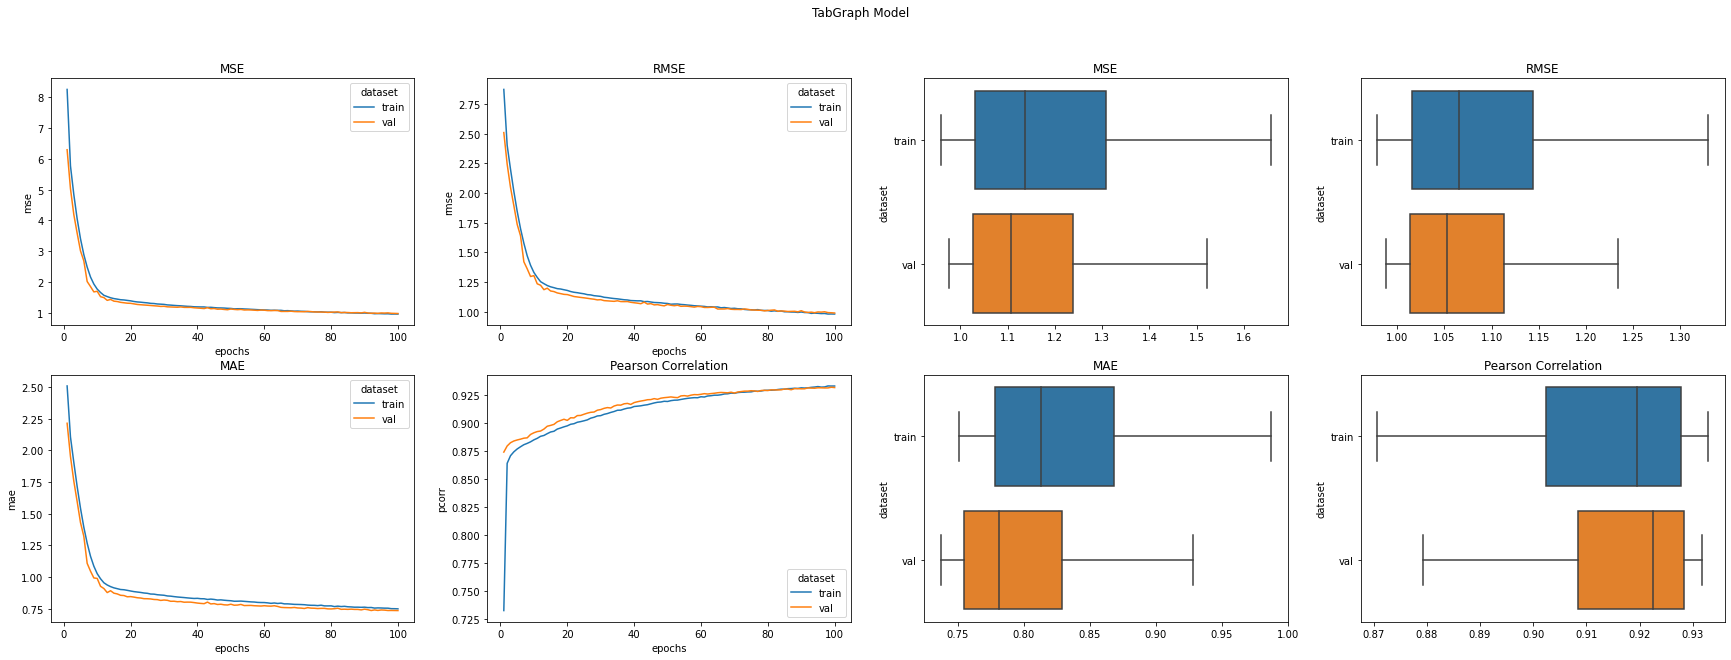

In [15]:
plot_model_results(train_val_per_model['TabGraph'], 'TabGraph')

In [27]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

with open('../../data/processed/' + 'gdsc2_drm.pkl', 'rb') as f: 
    drm = pickle.load(f)
with open('../../data/processed/gdsc2/990/' + f'thresh_gdsc2_990_gene_mat.pkl', 'rb') as f: 
    cl = pickle.load(f)
with open('../../data/processed/gdsc2/' + f'gdsc2_smiles_graphs.pkl', 'rb') as f:
    smiles = pickle.load(f)   
cl.set_index('CELL_LINE_NAME', inplace=True)
    
model = get_data_for_model_validation(
    tg, 
    create_tab_graph_datasets,
    TabGraph_v1, 
    BuildTabGraphModel,
    drm, 
    cl, 
    smiles,
    seed,
    'TabGraph'
)

TypeError: Can't instantiate abstract class TabGraphDataset with abstract methods get, len

In [17]:
test_res, ic50s = calculate_and_return_metrics(model, test_res, ic50s, 'TabGraph')

Iteration (val): 100%|██████████| 14/14 [00:05<00:00,  2.62it/s]

                 mse      rmse       mae        r2       pcc       scc
----------  --------  --------  --------  --------  --------  --------
train       0.750131  0.866101  0.660584  0.894393  0.946019  0.922804
validation  0.976124  0.98799   0.736819  0.862292  0.928834  0.904549
test        0.978758  0.989322  0.735769  0.862838  0.929099  0.908336


### Summary

For the following configurations
- number of epochs: 100
- combined score threshold: 990
- learning rate: 0.0001
- batch size: 1000
- seed: 42

Results for the test set:


In [19]:
test_res.to_csv('../performances/metrics_test_gdsc2_v1_100epochs.csv', index=False)
test_res

,model,mse,rmse,mae,r2,pcc,scc
0,TabTab,0.9352,0.967057,0.71581,0.868427,0.931941,0.911884
1,GraphTab,2.203784,1.484515,1.108914,0.690293,0.841992,0.802662
2,TabGraph,0.978758,0.989322,0.735769,0.862838,0.929099,0.908336


| Model         | MSE    | RMSE       | MAE    | r2         | PCC        | SCC    |
| ------------- | ------ | ---------- | ------ | ---------- | ---------- | ------ |
| TabTab        | 0.9352 | __0.9670__ | 0.7158 | __0.8684__ | __0.9319__ | 0.9118 | 
| GraphTab      | 2.2037 | 1.4845     | 1.1089 | 0.6902     | 0.8419     | 0.8026 | 
| TabGraph      | 0.9787 | 0.9893     | 0.7357 | 0.8628     | 0.9290     | 0.9083 | 
| GraphGraph    | | | | | | | 
| Linear Regr.  | 1.9755 | 6.3872     | 2.5273 | | 0.3167   | 0.3362 | 
| SVM           | | | | | | | 
| Random Forest | 1.9754 | 6.3836     | 2.5265 | | 0.3174   | 0.3372 |
| Drug Mean     | | | | | | |

In [31]:
ic50s.to_csv('../performances/ic50s_test_gdsc2_v1_100epochs.csv', index=False)
print(ic50s.shape)
ic50s.head(5)

(41349, 3)


,model,y_true,y_pred
0,TabTab,0.418922,0.330555
1,TabTab,5.516386,5.494784
2,TabTab,-3.588583,-2.162802
3,TabTab,2.089467,2.717782
4,TabTab,6.036913,5.513148


--- 

## Predicted vs Observed IC50s

In [83]:
ic50s = pd.read_csv('../performances/ic50s_test_gdsc2_v1_100epochs.csv')
print(ic50s.shape)

(41349, 3)


In [21]:
ic50s['y_true'] = ic50s['y_true'].astype(float)
ic50s['y_pred'] = ic50s['y_pred'].astype(float)

sns.set_theme(
    style='ticks', 
    rc={
    'axes.titlesize': PlottingParameters.TITLE_FONTSIZE.value + 3,
    'axes.labelsize': PlottingParameters.XLABEL_FONTSIZE.value + 3,
    'xtick.labelsize': PlottingParameters.XTICKS_LABELSIZE.value + 3,
    'ytick.labelsize': PlottingParameters.YTICKS_LABELSIZE.value + 3,   
});

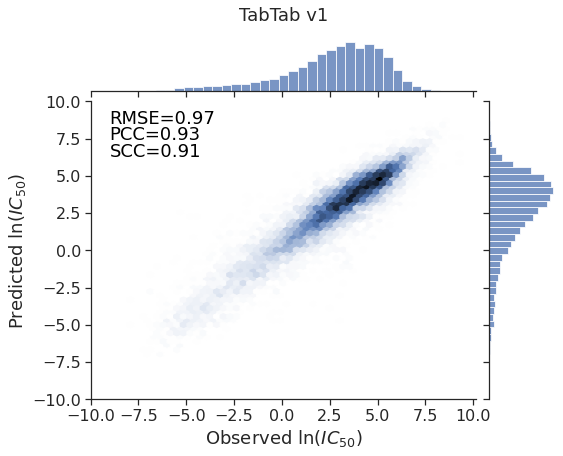

In [28]:
fig_tabtab = plot_observed_vs_predicted_ln_ic50s(
    ic50s.loc[ic50s.model=='TabTab'], 
    test_res.loc[test_res.model=='TabTab', 'rmse'].iloc[0],
    test_res.loc[test_res.model=='TabTab', 'pcc'].iloc[0],
    test_res.loc[test_res.model=='TabTab', 'scc'].iloc[0],      
    model_name='TabTab',
    version='v1'
)    
fig_tabtab.savefig('../performances/imgs/tabtab_v1_990_pred_vs_true_ic50s.svg', bbox_inches='tight')

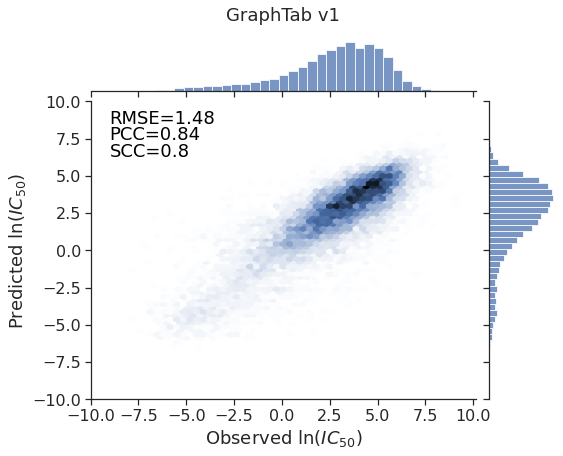

In [29]:
fig_graphtab = plot_observed_vs_predicted_ln_ic50s(
    ic50s.loc[ic50s.model=='GraphTab'], 
    test_res.loc[test_res.model=='GraphTab', 'rmse'].iloc[0],
    test_res.loc[test_res.model=='GraphTab', 'pcc'].iloc[0],
    test_res.loc[test_res.model=='GraphTab', 'scc'].iloc[0],      
    model_name='GraphTab',
    version='v1'
)    
fig_graphtab.savefig('../performances/imgs/graphtab_v1_990_pred_vs_true_ic50s.svg', bbox_inches='tight')

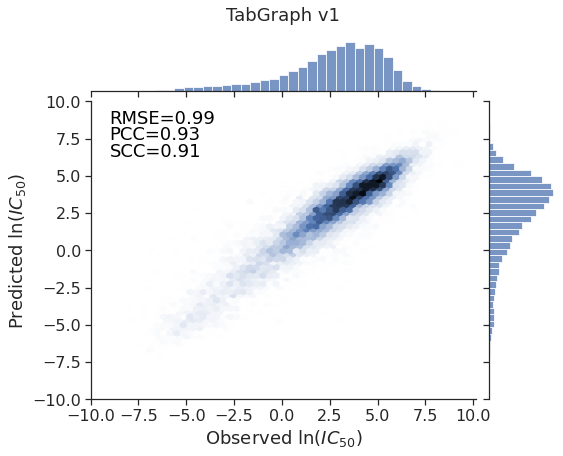

In [30]:
fig_tabgraph = plot_observed_vs_predicted_ln_ic50s(
    ic50s.loc[ic50s.model=='TabGraph'], 
    test_res.loc[test_res.model=='TabGraph', 'rmse'].iloc[0],
    test_res.loc[test_res.model=='TabGraph', 'pcc'].iloc[0],
    test_res.loc[test_res.model=='TabGraph', 'scc'].iloc[0],    
    model_name='TabGraph',
    version='v1'
)    
fig_tabgraph.savefig('../performances/imgs/tabgraph_v1_990_pred_vs_true_ic50s.svg', bbox_inches='tight')

- [ ] Do the above plots for the lnic50 values divided by the drug-mean as well

---

## GNNExplainer

- [PyTorch doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/explain.html?highlight=GNNExplainer#torch_geometric.explain.algorithm.GNNExplainer)
- [PyTorch code example](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gnn_explainer.py)

<ins>Notes:</ins>
- falls into the category of perturbation-based methods.
- consists of learning soft masks for edges and node features.
- to do so it starts by randomly initializing soft masks and combining them with the original graph via element-wise multiplications.
- then, the masks are optimized by maximizing the mutual information between the predictions of the original graph and the predictions of the newly obtained graph.

__Notes__:

- [GNNExplainer from version 2.0.3](https://pytorch-geometric.readthedocs.io/en/2.0.3/_modules/torch_geometric/nn/models/gnn_explainer.html) is the latest version where `visualize_subgraph` can be used

In [90]:
from torch_geometric.explain.algorithm import GNNExplainer

### GraphTab

In [91]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

with open('../../data/processed/' + 'gdsc2_drm.pkl', 'rb') as f: 
    drm = pickle.load(f)
with open('../../data/processed/gdsc2/990/' + f'thresh_gdsc2_990_gene_graphs.pkl', 'rb') as f: 
    cl = pickle.load(f)
with open('../../data/processed/gdsc2/' + f'gdsc2_smiles_dict.pkl', 'rb') as f:
    smiles = pickle.load(f)   

model = get_data_for_model_validation(
    gt, 
    create_graph_tab_datasets,
    GraphTab_v2, 
    BuildGraphTabModel,
    drm, 
    cl, 
    smiles,
    seed,
    'GraphTab'
)

Full     shape: (137835, 9)
train    shape: (110268, 9)
test_val shape: (27567, 9)
test     shape: (13783, 9)
val      shape: (13784, 9)
train_dataset:
GraphTabDataset Summary
# observations : 110268
# cell-lines   : 856
# drugs        : 181
# genes        : 293
test_dataset:
GraphTabDataset Summary
# observations : 13783
# cell-lines   : 856
# drugs        : 181
# genes        : 293
val_dataset:
GraphTabDataset Summary
# observations : 13784
# cell-lines   : 856
# drugs        : 181
# genes        : 293


In [27]:
model.val_loader.dataset.cell_lines.head(5)

0     CHSA8926
1    RPMI-8402
2        SW837
3       WM793B
4      NCI-H82
Name: CELL_LINE_NAME, dtype: object

In [28]:
model.val_loader.dataset.drug_ids.head(5)

0    1250
1    1049
2    1564
3    1067
4    1916
Name: DRUG_ID, dtype: int64

In [29]:
#model.val_loader.dataset[0] # gives cell-line graph for cell line CHSA8926, and SMILES string for drug 1250 and the corresponding ic50 value.

In [30]:
model.val_loader.dataset.cell_line_graphs.get('MOG-G-CCM').batch

In [31]:
for i, data in enumerate(model.val_loader):
    cell, drug, ic50s = data
    print(cell.batch)
    print(torch.stack(drug, 0).transpose(1, 0).float())
    print(torch.stack(drug, 0).transpose(1, 0).float().shape)
    break

tensor([  0,   0,   0,  ..., 999, 999, 999])
tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 1.]])
torch.Size([1000, 256])


In [32]:
torch.tensor([0])

tensor([0])

In [102]:
# --- Example cell-line drug combination ---
idx = 0
cl_drug_combi = model.val_loader.dataset[idx]
print(f"Testing for combination\n"\
      f"   cell-line: {model.val_loader.dataset.cell_lines[idx]}\n" \
      f"   drug     : {model.val_loader.dataset.drug_ids[idx]}")
G = cl_drug_combi[0]
drug = cl_drug_combi[1]
ic50 = cl_drug_combi[2]
G.y = ic50
print(G.x.shape)
print(G.edge_index.shape)
print(G)
print(len(drug))
print(ic50)
print(G.batch)

Testing for combination
   cell-line: CHSA8926
   drug     : 1250
torch.Size([293, 4])
torch.Size([2, 874])
Data(x=[293, 4], edge_index=[2, 874], y=1.287589)
256
1.287589
None


In [34]:
G.edge_index

tensor([[268, 222, 151,  ...,   1, 197, 194],
        [186, 247, 214,  ..., 221, 143, 114]])

In [35]:
print(torch.tensor(drug).float().reshape(1,256).shape)
torch.tensor(drug).float().reshape(1,256)

torch.Size([1, 256])


tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
         0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
         1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
         0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
         0., 0., 0., 0., 0.,

In [36]:
from torch_geometric.explain import Explainer, GNNExplainer
# from torch_geometric.nn import GNNExplainer

explainer = Explainer(
    model=model.model,
    algorithm=GNNExplainer(epochs=200),
    explainer_config=dict(
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',        
    ),
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw'
    )
)

In [37]:
explanation = explainer(
    G.x,
    G.edge_index,
    cell_batch=torch.tensor([0]),
    drug=torch.tensor(drug).double().reshape(1, 256)
)

TypeError: GraphTab_v2.forward() got an unexpected keyword argument 'x'

In [99]:
from torch_geometric.explain.algorithm import GNNExplainer

# --- Initialize Explainer ---
model.model.double()
gnn_explainer = GNNExplainer(
    model=model.model,
    epochs=100,
    return_type='regression',
    nhops=2
)

In [251]:
from torch_geometric.explain import Explainer, GNNExplainer

#     x=G.x, 
#     edge_index=G.edge_index,
#     cell_batch=torch.tensor([0]),
#     drug=torch.tensor(drug).double().reshape(1, 256)

model.model.to('cpu')

explainer = Explainer(
    model=model.model,
    algorithm=GNNExplainer(epochs=200,
                           return_type='regression',
                           nhops=2,
                           return_mask=True),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph'
    ),
)

G.to('cpu')
# drug.to('cpu')

node_index = 0
explanation = explainer(G.x, 
                        G.edge_index, 
                        cell_batch=torch.tensor([0]),
                        drug=torch.tensor(drug).double().reshape(1, 256),
                        index=node_index
                        )
print(f'Generated explanations in {explanation.available_explanations}')

path = 'feature_importance.png'
explanation.visualize_feature_importance(path, 
                                         feat_labels=['GExpr', 'CnvG', 'CnvP', 'Mut'],
                                         top_k=10)
print(f"Feature importance plot has been saved to '{path}'")

path = 'subgraph.pdf'
explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")

Generated explanations in ['edge_mask', 'node_mask']
Feature importance plot has been saved to 'feature_importance.png'
Subgraph visualization plot has been saved to 'subgraph.pdf'


In [116]:
G.x

tensor([[3.9390, 0.0000, 2.0000, 0.0000],
        [7.7586, 0.0000, 2.0000, 1.0000],
        [3.5385, 0.0000, 2.0000, 0.0000],
        ...,
        [3.4511, 1.0000, 3.0000, 0.0000],
        [4.6699, 0.0000, 2.0000, 0.0000],
        [8.5540, 0.0000, 2.0000, 0.0000]], dtype=torch.float64)

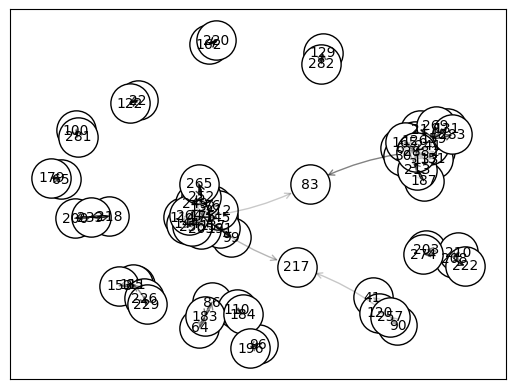

In [252]:
import torch
torch.manual_seed(123)

explanation = explainer(G.x, 
                        G.edge_index, 
                        cell_batch=torch.tensor([0]),
                        drug=torch.tensor(drug).double().reshape(1, 256)
#                         index=0
                        )

explanation.visualize_graph()

In [244]:
G.edge_index

tensor([[268, 222, 151,  ...,   1, 197, 194],
        [186, 247, 214,  ..., 221, 143, 114]])

In [248]:
G.edge_index[:, 85]

tensor([213, 288])

In [250]:
# Get the GENE_SYMBOL's of the main important edge.
gene_mapping = pd.read_csv('../../data/processed/sparse_inter_genes.csv')
gene_mapping[gene_mapping.GENE_INDEX.isin([213, 288])]

,GENE_SYMBOL,GENE_INDEX
213,MAN2B1,213
288,RFC2,288


> The `edge_mask` in _GNNExplainer_ is a tensor of shape `(num_edges,)` representing the importance score of each edge in the input graph.

- It is calculated by computing the difference between the GNN's output on the original graph and the GNN's output on a randomly perturbed version of the graph. 
- The larger the absolute value of an edge's score, the more important it is for the GNN's prediction.
- In other words, the edge_mask tells us which edges in the input graph are most important for the GNN's prediction. 
- This information can be used to visualize subgraphs or to identify important features in the graph.

In [191]:
gene_mapping = pd.read_csv('../../data/processed/sparse_inter_genes.csv')

# Get the edge mask tensor
edge_mask = explanation.edge_mask

# Select the top-k most important edges (genes)
k = 10
topk_values, topk_indices = torch.topk(edge_mask, k, largest=True)
topk_genes = gene_mapping[gene_mapping.GENE_INDEX.isin(topk_indices.tolist())]
topk_genes.insert(loc=2, column='values', value=[None] * len(topk_values))
for i, v in zip(topk_indices, topk_values):
    topk_genes.loc[i.item(), 'values'] = v.item()

# Print the indices of the top-k most important edges (genes)
print(f"Top-{k} most important genes:")
topk_genes

Top-10 most important genes:


,GENE_SYMBOL,GENE_INDEX,values
179,TRAM2,179,0.775041
214,ARL4C,214,0.770122
359,PTGS2,359,0.708493
396,NR2F6,396,0.808171
449,TUBB6,449,0.70107
453,RRAGA,453,0.791214
502,APP,502,0.711843
577,TM9SF2,577,0.720463
649,LSR,649,0.699656
685,CDC25A,685,0.747


In [159]:
torch.topk(edge_mask, k, largest=True)

torch.return_types.topk(
values=tensor([0.8082, 0.7912, 0.7750, 0.7701, 0.7470, 0.7205, 0.7118, 0.7085, 0.7011,
        0.6997]),
indices=tensor([396, 453, 179, 214, 685, 577, 502, 359, 449, 649]))

In [205]:
k = 20
topk_values, topk_indices = torch.topk(edge_mask, k, largest=True)
topk_genes = gene_mapping[gene_mapping.GENE_INDEX.isin(topk_indices.tolist())]
for i in topk_indices.tolist():
    print(f"i: {i}  is in --> {[i in list(gene_mapping.GENE_INDEX.values)]}")

i: 396  is in --> [True]
i: 453  is in --> [True]
i: 179  is in --> [True]
i: 214  is in --> [True]
i: 685  is in --> [True]
i: 577  is in --> [True]
i: 502  is in --> [True]
i: 359  is in --> [True]
i: 449  is in --> [True]
i: 649  is in --> [True]
i: 332  is in --> [True]
i: 488  is in --> [True]
i: 684  is in --> [True]
i: 859  is in --> [False]
i: 754  is in --> [True]
i: 106  is in --> [True]
i: 699  is in --> [True]
i: 652  is in --> [True]
i: 628  is in --> [True]
i: 495  is in --> [True]


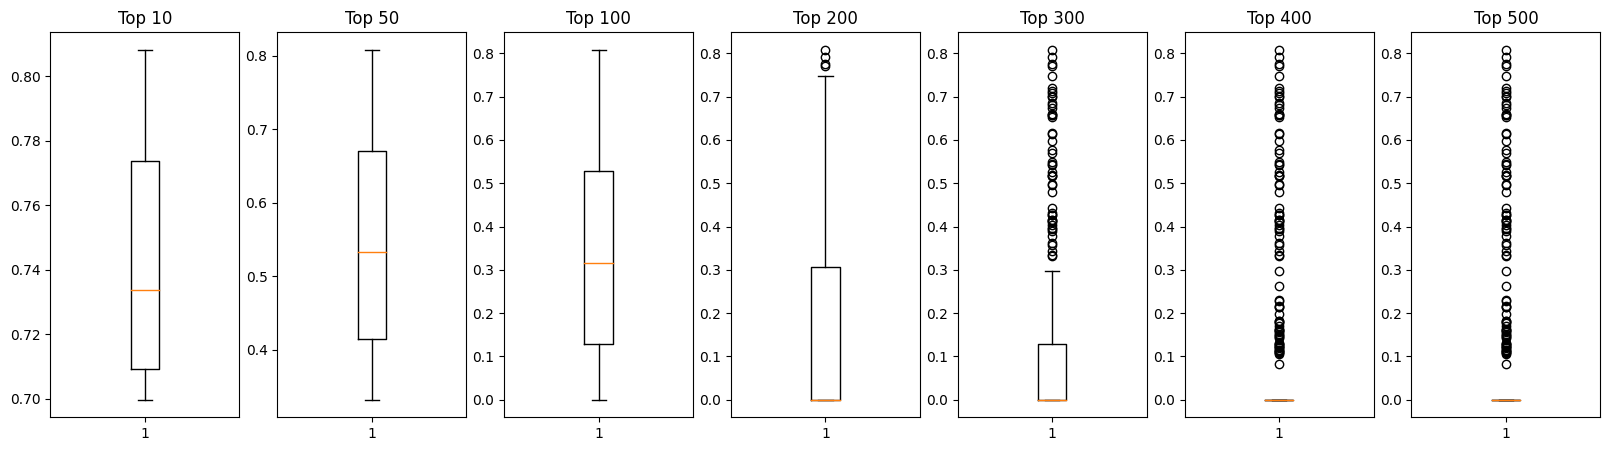

In [243]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 7, figsize=(20, 5))

# Create the first boxplot
for i, k in enumerate([10, 50, 100, 200, 300, 400, 500]):
    topk_values, topk_indices = torch.topk(edge_mask, k, largest=True)
    axs[i].boxplot(topk_values); axs[i].set_title(f"Top {k}")

# Display the plot
plt.show()

Generated explanations in ['edge_mask', 'node_mask']


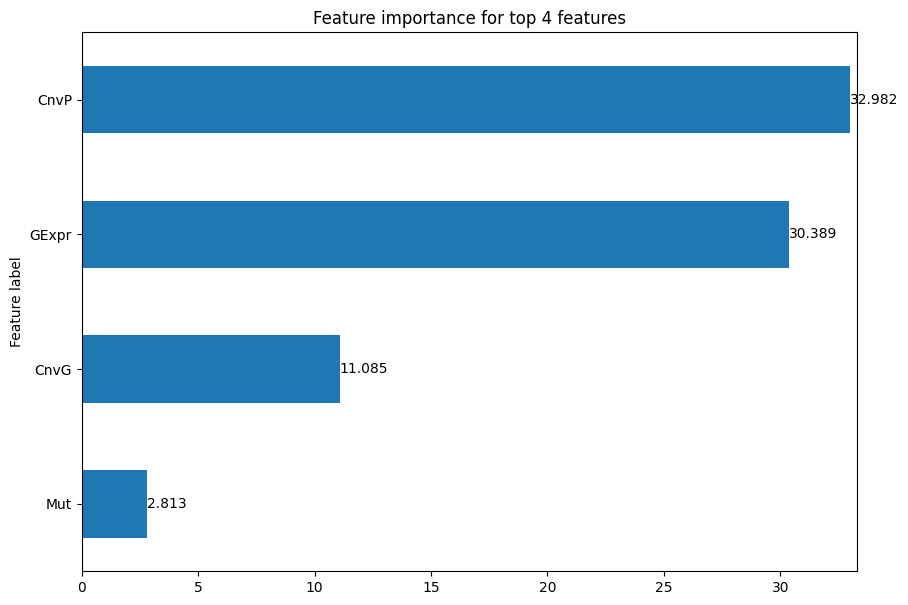

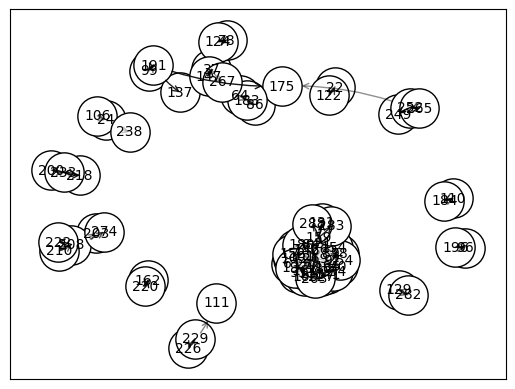

In [283]:
from torch_geometric.explain import Explainer, GNNExplainer

model.model.to('cpu')

explainer = Explainer(
    model=model.model,
    algorithm=GNNExplainer(epochs=200,
                           return_type='regression',
                           nhops=2,
                           return_mask=True),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw'
    ),
)

G.to('cpu')

node_index = 0
explanation = explainer(G.x, 
                        G.edge_index, 
                        cell_batch=torch.tensor([0]),
                        drug=torch.tensor(drug).double().reshape(1, 256),
                        index=node_index
                        )
print(f'Generated explanations in {explanation.available_explanations}')

explanation.visualize_feature_importance(feat_labels=['GExpr', 'CnvG', 'CnvP', 'Mut'],
                                         top_k=10)

explanation.visualize_graph()

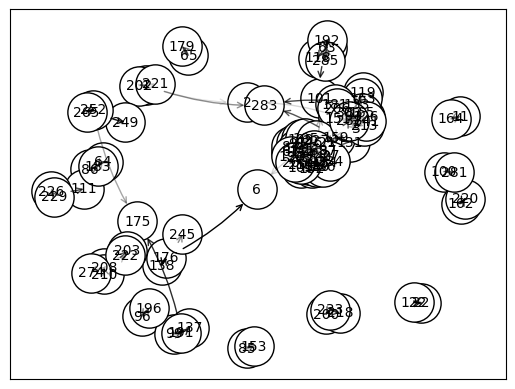

In [271]:
explanation.visualize_graph()

In [272]:
from torch_geometric.nn.models.expl 

ModuleNotFoundError: No module named 'torch_geometric.nn.models.explainer'

### TabGraph

In [43]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

with open('../../data/processed/' + 'gdsc2_drm.pkl', 'rb') as f: 
    drm = pickle.load(f)
with open('../../data/processed/gdsc2/990/' + f'thresh_gdsc2_990_gene_mat.pkl', 'rb') as f: 
    cl = pickle.load(f)
with open('../../data/processed/gdsc2/' + f'gdsc2_smiles_graphs.pkl', 'rb') as f:
    smiles = pickle.load(f)   
cl.set_index('CELL_LINE_NAME', inplace=True)
    
model = get_data_for_model_validation(
    tg, 
    create_tab_graph_datasets,
    TabGraph_v1, 
    BuildTabGraphModel,
    drm, 
    cl, 
    smiles,
    seed,
    'TabGraph'
)

In [44]:
model.val_loader.dataset.drug_ids[:10]

0    1250
1    1049
2    1564
3    1067
4    1916
5    1093
6    1038
7    1021
8    1614
9    1915
Name: DRUG_ID, dtype: int64

In [58]:
# Initialize Explainer.
explainer = GNNExplainer(
    model=model.model,
    epochs=2,
    return_type='regression',
#     feat_mask_type='feature',
#     allow_edge_mask=True,
    nhops=2
)

In [69]:
for data in model.val_loader:
    cell, drug, ic50 = data
    drug.y = ic50
    print(drug)
    break
G = drug
print(G.x.shape)
print(G.edge_index.shape)
print(G.y[:10])

DataBatch(x=[31294, 9], edge_index=[2, 68772], edge_attr=[68772, 3], smiles=[1000], batch=[31294], ptr=[1001], y=[1000])
torch.Size([31294, 9])
torch.Size([2, 68772])
tensor([-0.5597, -2.9528,  5.2254,  3.2985,  0.4312, -4.6706, -1.9874,  3.9925,
        -2.9445,  4.7274])


In [72]:
torch.stack(cell, 0).transpose(1, 0).float()

tensor([[3.7786, 8.3231, 3.2138,  ..., 0.0000, 0.0000, 0.0000],
        [3.7870, 9.1227, 3.2696,  ..., 0.0000, 0.0000, 0.0000],
        [3.6516, 6.9799, 3.0286,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [3.7704, 9.2162, 4.1082,  ..., 0.0000, 0.0000, 0.0000],
        [3.9622, 7.9626, 4.1039,  ..., 0.0000, 0.0000, 1.0000],
        [3.7641, 8.0261, 3.2946,  ..., 0.0000, 0.0000, 0.0000]])

In [67]:
# Explain node.
node_idx = 2
node_feat_mask, edge_mask = explainer.explain_node(
    node_idx, 
    G.x,
    G.edge_index,
    cell=torch.stack(cell, 0).transpose(1, 0).float(),
    drug=drug
)

TypeError: TabGraph_v1.forward() got multiple values for argument 'cell'

In [56]:
G = model.val_loader.dataset.drug_graphs[1049]
print(G.x.shape)
print(G.edge_index.shape)

torch.Size([38, 9])
torch.Size([2, 80])


In [57]:
G

Data(x=[38, 9], edge_index=[2, 80], edge_attr=[80, 3], smiles='CCN(CC)CCCCN=c1ncc2cc(c3cc(cc(c3)OC)OC)c(nc2[nH]1)N=C(NC(C)(C)C)O')

In [55]:
# Explain node.
node_idx = 2
node_feat_mask, edge_mask = explainer.explain_node(
    node_idx, 
    G.x,
    G.edge_index,
    
)

RuntimeError: mat1 and mat2 must have the same dtype

In [226]:
model.val_loader.dataset.drug_graphs[1003].x

tensor([[6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 1, 4, 5, 0, 0, 4, 0, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [7, 0, 2, 5, 0, 0, 3, 1, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 1],
        [7, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [8, 0, 1, 5, 0, 0, 3, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 3, 0, 1],
        [6, 0, 3, 5, 0, 0, 3, 0, 1],
        [8, 0, 1, 5, 0, 0, 3, 0, 0],
        [8, 0, 2, 5, 1, 0, 4, 0, 0]])

In [228]:
model.val_loader.dataset.drug_graphs[1003].edge_index

tensor([[ 0,  1,  1,  2,  2,  2,  2,  3,  3,  3,  4,  4,  5,  5,  5,  6,  6,  6,
          7,  7,  7,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14,
         14, 15, 15, 16, 16, 17, 17, 17, 18, 18, 18, 19, 20, 20, 20, 21, 21, 22,
         22, 23, 23, 23, 24, 25],
        [ 1,  0,  2,  1,  3, 23, 25,  2,  4, 20,  3,  5,  4,  6, 17,  5,  7, 15,
          6,  8, 16,  7,  9,  8, 10, 14,  9, 11, 10, 12, 11, 13, 12, 14,  9, 13,
         15,  6, 14,  7, 17,  5, 16, 18, 17, 19, 20, 18,  3, 18, 21, 20, 22, 21,
         23,  2, 22, 24, 23,  2]])

In [229]:
model.val_loader.dataset.drug_graphs[1003]

Data(x=[26, 9], edge_index=[2, 60], edge_attr=[60, 3], smiles='CC[C@@]1(c2cc3c4c(cc5ccccc5n4)Cn3c(=O)c2COC1=O)O')

In [ ]:
x, edge_i, edge_t = graph_data.x_user, graph_data.edge_index_user, graph_data.edge_type_user
xi, edge_ii, edge_ti = graph_data.x_item, graph_data.edge_index_item, graph_data.edge_type_item

explainer.explain_graph(
    x=x, 
    edge_index=edge_index, 
    edge_type_user=edge_type, 
    x_item=xi, 
    edge_index_item=edge_indexi, 
    edge_type_item=edge_typei
)

In [239]:
for data in model.val_loader:
    cell, drug, ic50s = data
    print(len(cell))
    print(drug)
    break

1172
DataBatch(x=[31541, 9], edge_index=[2, 69244], edge_attr=[69244, 3], smiles=[1000], batch=[31541], ptr=[1001])


In [248]:
drug

DataBatch(x=[31541, 9], edge_index=[2, 69244], edge_attr=[69244, 3], smiles=[1000], batch=[31541], ptr=[1001])

In [251]:
torch.stack(cell, 0).transpose(1, 0)

tensor([[3.7427, 7.8459, 3.4596,  ..., 0.0000, 0.0000, 0.0000],
        [3.8839, 8.4314, 3.5929,  ..., 0.0000, 0.0000, 0.0000],
        [5.0053, 8.9406, 3.1268,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [5.4157, 8.8205, 3.6573,  ..., 0.0000, 1.0000, 0.0000],
        [3.9901, 8.5271, 3.8902,  ..., 0.0000, 0.0000, 0.0000],
        [3.5029, 8.3078, 3.3360,  ..., 0.0000, 0.0000, 0.0000]])

In [279]:
temp = model.val_loader.dataset.drug_graphs[1003]

explainer.explain_graph(
    x=drug.x,
    edge_index=drug.edge_index,
    drug=1 #torch.stack(cell, 0).transpose(1, 0)
)

TypeError: TabGraph_v1.forward() got multiple values for argument 'drug'

In [221]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Explainer, GNNExplainer
from torch_geometric.nn import GCNConv

dataset = 'Cora'
dataset = Planetoid('hallo', dataset)
data = dataset[0]

Processing...
Done!


In [222]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [225]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [27]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

from models.GraphTab.graph_tab import GraphTab_v1, GraphTabDataset, create_graph_tab_datasets, BuildGraphTabModel



with open('../../data/processed/' + 'gdsc2_drm.pkl', 'rb') as f: 
    drm = pickle.load(f)
with open('../../data/processed/gdsc2/990/' + f'thresh_gdsc2_990_gene_graphs.pkl', 'rb') as f: 
    cl = pickle.load(f)
with open('../../data/processed/gdsc2/' + f'gdsc2_smiles_dict.pkl', 'rb') as f:
    smiles = pickle.load(f)   

model = get_data_for_model_validation(
    gt, 
    create_graph_tab_datasets,
    GraphTab_v1, 
    BuildGraphTabModel,
    drm, 
    cl, 
    smiles,
    seed,
    'GraphTab'
)

te_mse, te_rmse, te_mae, te_r2, te_r, te_y_true, te_y_pred = model.validate(model.test_loader)

data = np.stack([
    np.repeat('GraphTab', len(te_y_true)),
    list([v.item() for v in te_y_true]), 
    list([v.item() for v in te_y_pred])
], axis=1)

if 'GraphTab' not in list(ic50s.model.unique()):
    ic50s = pd.concat([ic50s, pd.DataFrame(data, columns=df.columns)], axis=0)
print(ic50s.shape)    

Iteration (Val): 100%|██████████| 14/14 [00:14<00:00,  1.01s/it]

(13783, 3)


In [212]:
np.stack([[1,1,1], [2,2,2]], axis=1)

array([[1, 2],
       [1, 2],
       [1, 2]])

In [18]:
data = np.stack([
    np.repeat('GraphTab', len(te_y_true)),
    list([v.item() for v in te_y_true]), 
    list([v.item() for v in te_y_pred])
], axis=1)
data

array([['GraphTab', '1.3787360191345215', '0.8904538750648499'],
       ['GraphTab', '-6.4930901527404785', '-5.587874412536621'],
       ['GraphTab', '-2.649991035461426', '-0.11033904552459717'],
       ...,
       ['GraphTab', '1.3990709781646729', '2.3332066535949707'],
       ['GraphTab', '4.347847938537598', '4.522904396057129'],
       ['GraphTab', '5.030540943145752', '4.096922397613525']],
      dtype='<U32')

In [21]:
ic50s = pd.DataFrame(columns=['model', 'y_true', 'y_pred'])
ic50s = pd.concat([ic50s, pd.DataFrame(data, columns=df.columns)], axis=0)
ic50s

,model,y_true,y_pred
0,GraphTab,1.3787360191345215,0.8904538750648499
1,GraphTab,-6.4930901527404785,-5.587874412536621
2,GraphTab,-2.649991035461426,-0.11033904552459717
3,GraphTab,3.2968618869781494,0.6588293313980103
4,GraphTab,5.87383508682251,5.405949115753174
...,...,...,...
13778,GraphTab,2.6645309925079346,2.711752414703369
13779,GraphTab,2.608319044113159,1.9397351741790771
13780,GraphTab,1.3990709781646729,2.3332066535949707
13781,GraphTab,4.347847938537598,4.522904396057129


In [13]:
pd.concat([df, pd.DataFrame().from_records(data, columns=['model', 'y_true', 'y_pred'])], axis=0)

,model,y_true,y_pred
0,GraphTab,1.3787360191345215,0.8904538750648499
1,GraphTab,-6.4930901527404785,-5.587874412536621
2,GraphTab,-2.649991035461426,-0.11033904552459717
3,GraphTab,3.2968618869781494,0.6588293313980103
4,GraphTab,5.87383508682251,5.405949115753174
...,...,...,...
13778,GraphTab,2.6645309925079346,2.711752414703369
13779,GraphTab,2.608319044113159,1.9397351741790771
13780,GraphTab,1.3990709781646729,2.3332066535949707
13781,GraphTab,4.347847938537598,4.522904396057129


In [209]:
ic50s = pd.DataFrame({
    'model': [None],
    'y_true': [None],
    'y_pred': [None]
})

ic50s['y_true'] = list([v.item() for v in te_y_true])
# ic50s['y_pred'] = list([v.item() for v in te_y_pred])
# ic50s['model'] = np.repeat('GraphTab', len(te_y_true))
print(ic50s.shape)
ic50s.head(5)

ValueError: Length of values (13783) does not match length of index (1)

Iteration (Val): 100%|██████████| 14/14 [00:14<00:00,  1.04s/it]


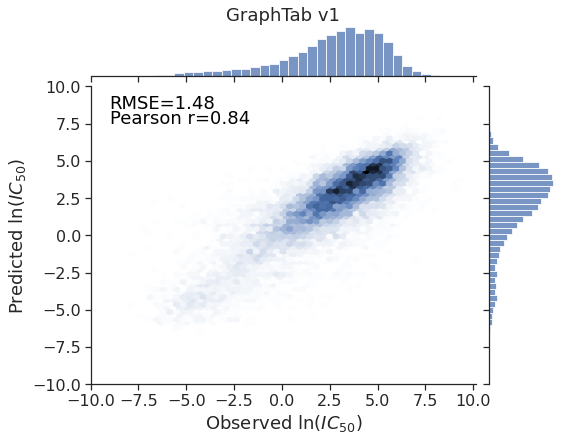

In [203]:
def plot_observed_vs_predicted_ln_ic50s(ic50s: pd.DataFrame, 
                                        rmse: 
                                        version: str):
    ax = sns.jointplot(x='y_true', y='y_pred', data=ic50s, kind='hex',
                      marginal_kws={'bins': 35});
    ax.fig.set_size_inches(8, 6);

    plt.xlabel(r'Observed $\ln(IC_{50})$');
    plt.ylabel(r'Predicted $\ln(IC_{50})$');
    plt.xticks(np.arange(-10, 11, 2.5));
    plt.yticks(np.arange(-10, 11, 2.5));

    plt.text(-9, 8.5, 
             f"RMSE={round(te_rmse.item(), 2)}", 
             horizontalalignment='left', size=18, color='black');
    plt.text(-9, 7.5, 
             f"Pearson r={round(te_r, 2)}", 
             horizontalalignment='left', size=18, color='black');

    plt.title(f'{model} {version}', y=1.2);
    plt.show();
    
plot_observed_vs_predicted_ln_ic50s(
    ic50s[ic50s.model='GraphTab'], 
    te_rmse.item()
    version='v1')    

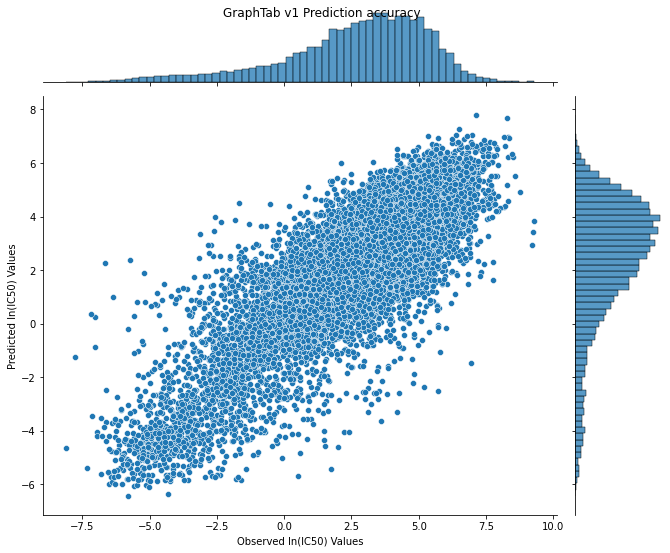

In [44]:

ax = sns.jointplot(x='y_true', y='y_pred', data=test_ic50s);
ax.fig.set_size_inches(10,8)

plt.xlabel('Observed ln(IC50) Values');
plt.ylabel('Predicted ln(IC50) Values');
plt.suptitle("GraphTab v1 Prediction accuracy");
plt.show();

# Todo

- [ ] Add comparison for baseline models like RandomForest and SVM
- [ ] compare generated ic50 scores of the model vs the actual ic50 scores in the validation set
    - [ ] plot them against one another
    - [ ] add them to the output and save maybe also in the dictionary in the main
- [ ] run GNNExplainer on the TabGraph or GraphTab model